In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, add_dummy_feature
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

np.random.seed(42)

In [73]:
df = pd.read_csv('gas0.csv', index_col=0)
df

,gas_pumped,vehicle_tons
0,4.863340,0.876393
1,5.221294,0.289274
2,5.753711,0.551745
5,7.491693,1.746046
6,8.953863,3.436751
...,...,...
209,8.276677,1.267911
210,11.561033,3.320541
211,6.285658,1.174349
214,3.344203,0.129916


In [74]:
df = df.sample(n=20, random_state=42)
df

,gas_pumped,vehicle_tons
192,9.012933,3.037586
180,8.611575,2.008066
124,7.624183,1.795582
158,9.158680,2.636876
176,7.162991,1.313272
173,7.450144,1.889522
52,4.272429,0.334776
19,7.002699,1.088526
157,3.845650,0.290055
79,8.018104,2.255932


In [75]:
X = df[['vehicle_tons']]
y = df['gas_pumped']

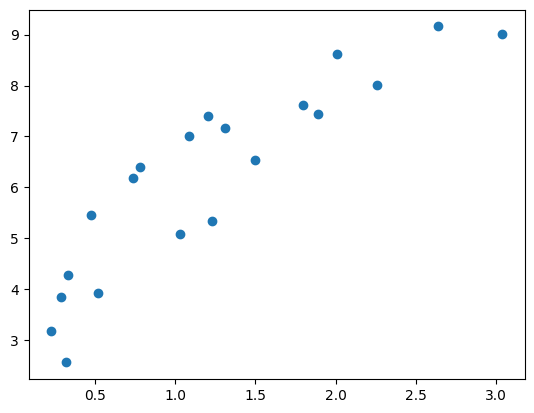

In [76]:
plt.scatter(df['vehicle_tons'], df['gas_pumped'])
plt.show()

In [77]:
n_poly = 10
poly = PolynomialFeatures(n_poly, include_bias=False)
X_poly = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_poly,
                                                    y,
                                                    train_size=0.8,
                                                    random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = np.concatenate([X_train_scaled, X_test_scaled])
X_train_scaled_w_dummy = add_dummy_feature(scaler.fit_transform(X_train))
X_test_scaled_w_dummy = add_dummy_feature(scaler.transform(X_test))
y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)

In [78]:
weights_unregged = np.random.randn(n_poly+1).reshape(-1,1)
n = X_train_scaled.shape[0]
learning_rate = 0.1
epochs = 10000
line_history = []

for i in range(epochs):
    Y_pred = (X_train_scaled_w_dummy@weights_unregged)
    # solve for all weights at once
    D_m = (-2/n) * X_train_scaled_w_dummy.T @ (y_train - Y_pred)
    weights_unregged = weights_unregged - learning_rate*D_m
    line_history.append({'epoch':i,'loss':np.sum((y_train-Y_pred)**2/n)})

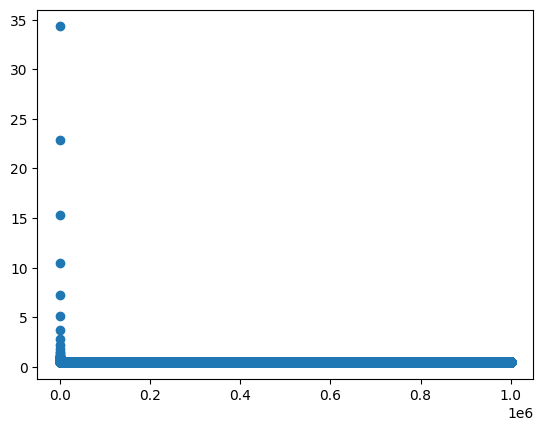

In [79]:
line_history_df = pd.DataFrame(line_history)
plt.scatter(line_history_df['epoch'], line_history_df['loss'])
plt.show()

In [80]:
min(line_history_df['loss'])

0.45145859084829926

In [81]:
n_new = 5000
X_new = np.linspace(min(df['vehicle_tons'])-1, max(df['vehicle_tons'])+1, n_new).reshape(-1,1)
X_new_df = pd.DataFrame(X_new, columns=['vehicle_tons'])
X_new_scaled = scaler.transform(poly.transform(X_new_df))
X_new_w_dummy = add_dummy_feature(X_new_scaled)
Y_pred_unregged = (X_new_w_dummy@weights_unregged)
Y_pred_unregged.shape

(5000, 1)

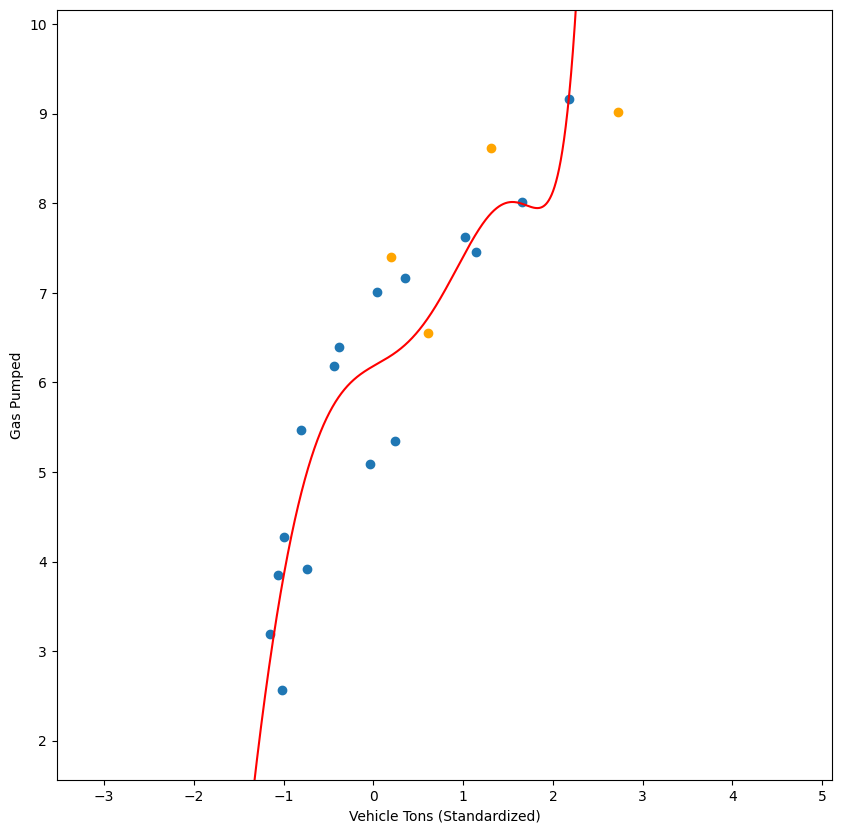

In [82]:
plt.figure(figsize=(10,10))
plt.scatter(X_train_scaled[:,0],y_train)
plt.scatter(X_test_scaled[:,0],y_test, c='orange')
plt.plot(X_new_scaled[:,0], Y_pred_unregged, c='red')
plt.xlim(min(X_new_scaled[:,0])-1, max(X_new_scaled[:,0])+1)
plt.ylim(min(y)-1, max(y)+1)
plt.xlabel('Vehicle Tons (Standardized)')
plt.ylabel('Gas Pumped')
plt.show()

In [67]:
weights_regged = np.zeros((n_poly+1, 1))
n = X_train_scaled.shape[0]
alpha = 1
line_history = []
for i in range(epochs):
    Y_pred = (X_train_scaled_w_dummy@weights_regged)
    weights_replace_bias = weights_regged.copy()
    weights_replace_bias[0] = 0
    # solve for all weights at once
    D_m = (-2/n) * X_train_scaled_w_dummy.T @ (y_train - Y_pred) + 2*alpha/n*weights_replace_bias
    weights_regged = weights_regged - learning_rate*D_m
    loss = np.sum((y_train-Y_pred)**2/n)
    line_history.append({'epoch':i,'loss':loss})

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


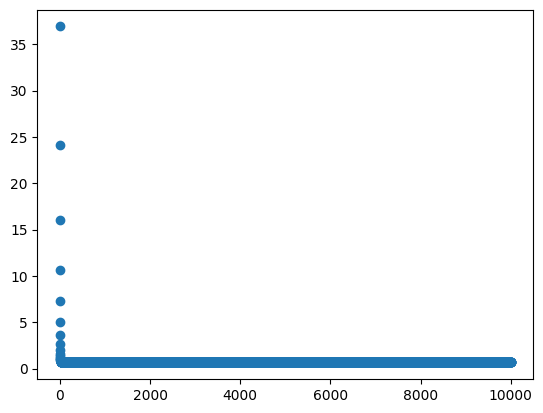

In [68]:
line_history_df = pd.DataFrame(line_history)
plt.scatter(line_history_df['epoch'], line_history_df['loss'])
plt.show()

In [69]:
min(line_history_df['loss'])

0.6581814729207924

In [70]:
Y_pred_regged = (X_new_w_dummy@weights_regged)
Y_pred_regged.shape

(5000, 1)

In [16]:
reg = LinearRegression()
reg.fit(scaler.transform(X_train), y_train)

ridge_reg = Ridge(alpha=0.1)
ridge_reg.fit(scaler.transform(X_train), y_train)

Ridge(alpha=0.1)

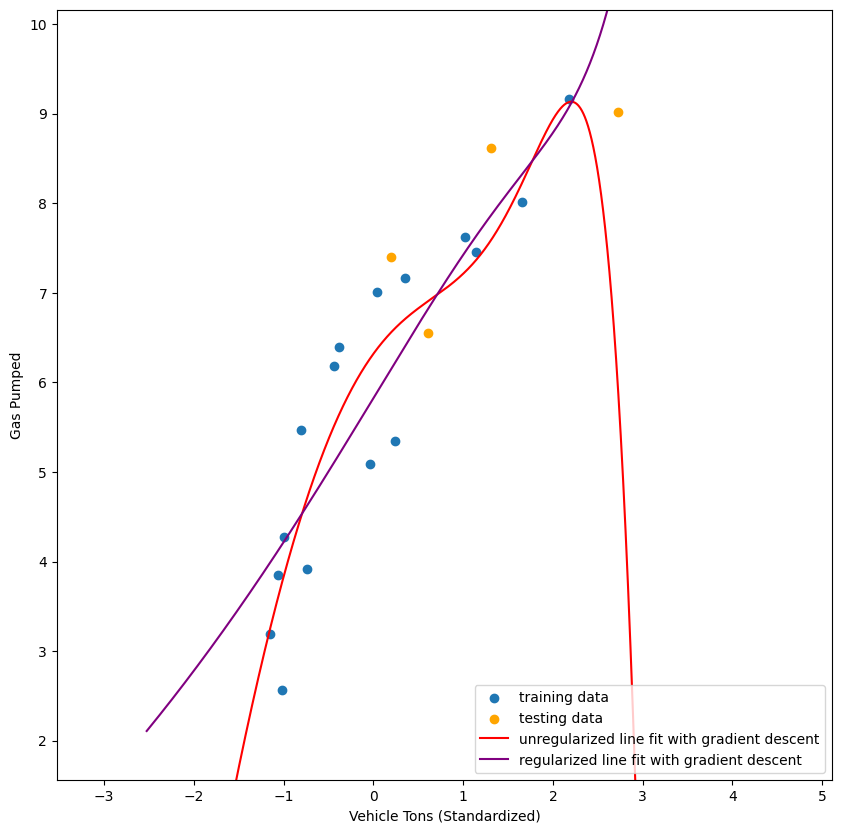

In [17]:
plt.figure(figsize=(10,10))
plt.scatter(X_train_scaled[:, 0], y_train, label='training data')
plt.scatter(X_test_scaled[:, 0], y_test, c='orange', label='testing data')
plt.plot(X_new_scaled[:,0], Y_pred_unregged, c='red', label='unregularized line fit with gradient descent')
plt.plot(X_new_scaled[:,0], Y_pred_regged, c='purple', label='regularized line fit with gradient descent')
plt.xlim(min(X_new_scaled[:,0])-1, max(X_new_scaled[:,0])+1)
plt.ylim(min(y)-1, max(y)+1)
plt.xlabel('Vehicle Tons (Standardized)')
plt.ylabel('Gas Pumped')
plt.legend(loc = 'lower right')
plt.show()

In [18]:
y_pred_train_unregged = (X_train_scaled_w_dummy@weights_unregged)
y_pred_test_unregged = (X_test_scaled_w_dummy@weights_unregged)

y_pred_train_regged = (X_train_scaled_w_dummy@weights_regged)
y_pred_test_regged = (X_test_scaled_w_dummy@weights_regged)

In [19]:
print(f'Unregularized gradient descent solution train mean squared error: {mean_squared_error(y_train, y_pred_train_unregged)}')
print(f'Unregularized gradient descent solution test mean squared error: {mean_squared_error(y_test, y_pred_test_unregged)}')
print(f'Regularized gradient descent solution train mean squared error: {mean_squared_error(y_train, y_pred_train_regged)}')
print(f'Regularized gradient descent solution test mean squared error: {mean_squared_error(y_test, y_pred_test_regged)}')

Unregularized gradient descent solution train mean squared error: 0.49914859612968077
Unregularized gradient descent solution test mean squared error: 2.94538427037698
Regularized gradient descent solution train mean squared error: 0.6581814729207927
Regularized gradient descent solution test mean squared error: 1.2293906395690632


In [20]:
reg = LinearRegression()
reg.fit(X_train_scaled, y_train)


LinearRegression()

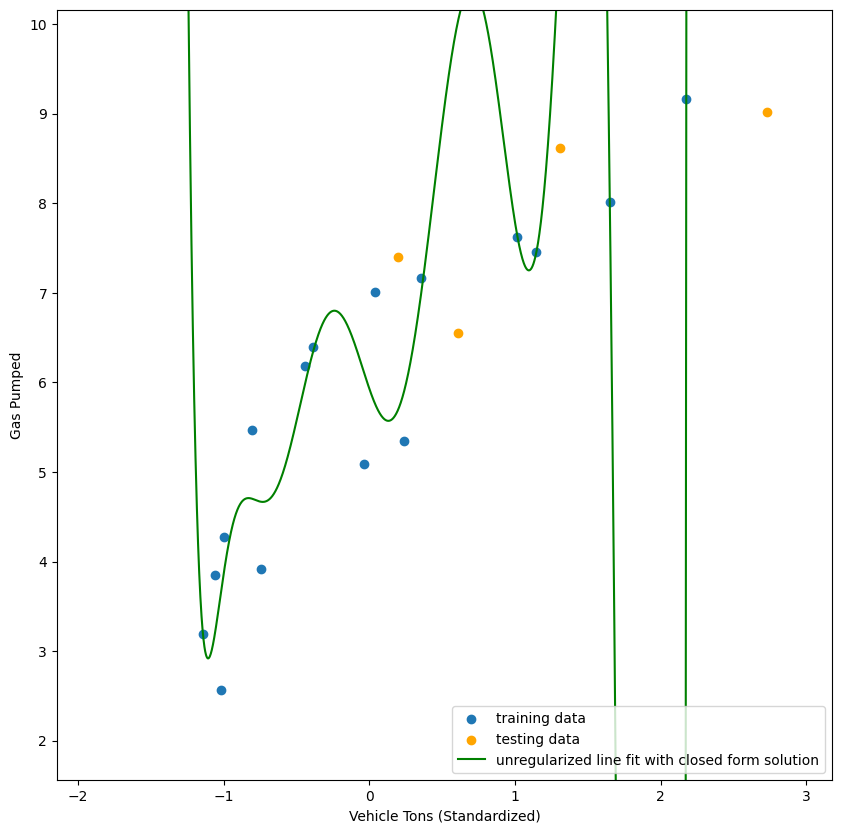

In [21]:
plt.figure(figsize=(10,10))
plt.scatter(X_train_scaled[:, 0], y_train, label='training data')
plt.scatter(X_test_scaled[:, 0], y_test, c='orange', label='testing data')
plt.plot(X_new_scaled[:, 0], reg.predict(X_new_scaled), c='green', label='unregularized line fit with closed form solution')
plt.xlim(min(X_train_scaled[:, 0])-1, max(X_train_scaled[:, 0])+1)
plt.ylim(min(y)-1, max(y)+1)
plt.xlabel('Vehicle Tons (Standardized)')
plt.ylabel('Gas Pumped')
plt.legend(loc = 'lower right')
plt.show()

In [22]:
ridge_reg = Ridge(alpha=0.1)
ridge_reg.fit(X_train_scaled, y_train)

Ridge(alpha=0.1)

In [23]:
ridge_reg.coef_

array([[ 2.58677901, -0.36239962, -0.71987148, -0.4151634 , -0.12213498,
         0.0518848 ,  0.13681546,  0.1713708 ,  0.18044211,  0.17737437]])

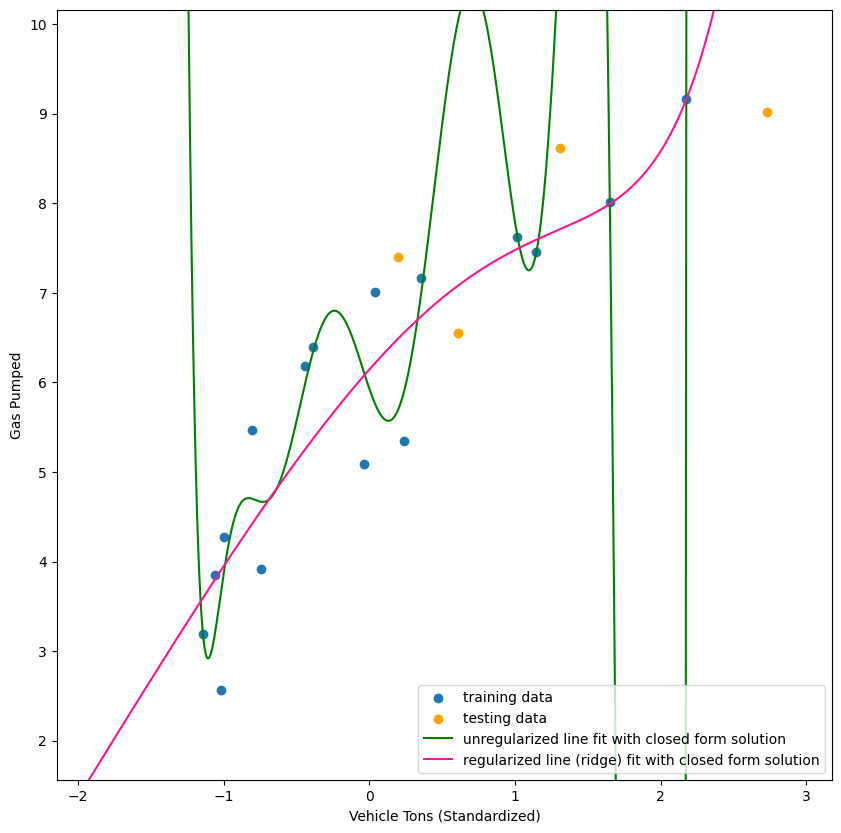

In [24]:
plt.figure(figsize=(10,10))
plt.scatter(X_train_scaled[:, 0], y_train, label='training data')
plt.scatter(X_test_scaled[:, 0], y_test, c='orange', label='testing data')
plt.plot(X_new_scaled[:, 0], reg.predict(X_new_scaled), c='green', label='unregularized line fit with closed form solution')
plt.plot(X_new_scaled[:, 0], ridge_reg.predict(X_new_scaled), c='deeppink', label='regularized line (ridge) fit with closed form solution')
plt.xlim(min(X_train_scaled[:, 0])-1, max(X_train_scaled[:, 0])+1)
plt.ylim(min(y)-1, max(y)+1)
plt.xlabel('Vehicle Tons (Standardized)')
plt.ylabel('Gas Pumped')
plt.legend(loc = 'lower right')
plt.show()

In [25]:
y_pred_train_unregged_closed_form = reg.predict(X_train_scaled)
y_pred_test_unregged_closed_form = reg.predict(X_test_scaled)

y_pred_train_regged_closed_form = ridge_reg.predict(X_train_scaled)
y_pred_test_regged_closed_form = ridge_reg.predict(X_test_scaled)

In [26]:
print(f'Unregularized closed form solution train mean squared error: {mean_squared_error(y_train, y_pred_train_unregged_closed_form)}')
print(f'Unregularized closed form solution test mean squared error: {mean_squared_error(y_test, y_pred_test_unregged_closed_form)}')
print(f'Regularized (ridge) closed form solution train mean squared error: {mean_squared_error(y_train, y_pred_train_regged_closed_form)}')
print(f'Regularized (ridge) closed form solution test mean squared error: {mean_squared_error(y_test, y_pred_test_regged_closed_form)}')

Unregularized closed form solution train mean squared error: 0.3661147036640688
Unregularized closed form solution test mean squared error: 67776693.09950213
Regularized (ridge) closed form solution train mean squared error: 0.5447398425909047
Regularized (ridge) closed form solution test mean squared error: 6.549537140865745


In [27]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train_scaled, y_train)

Lasso(alpha=0.1)

In [28]:
lasso_reg.intercept_

array([5.79286388])

In [29]:
lasso_reg.coef_

array([ 1.54484657,  0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ])

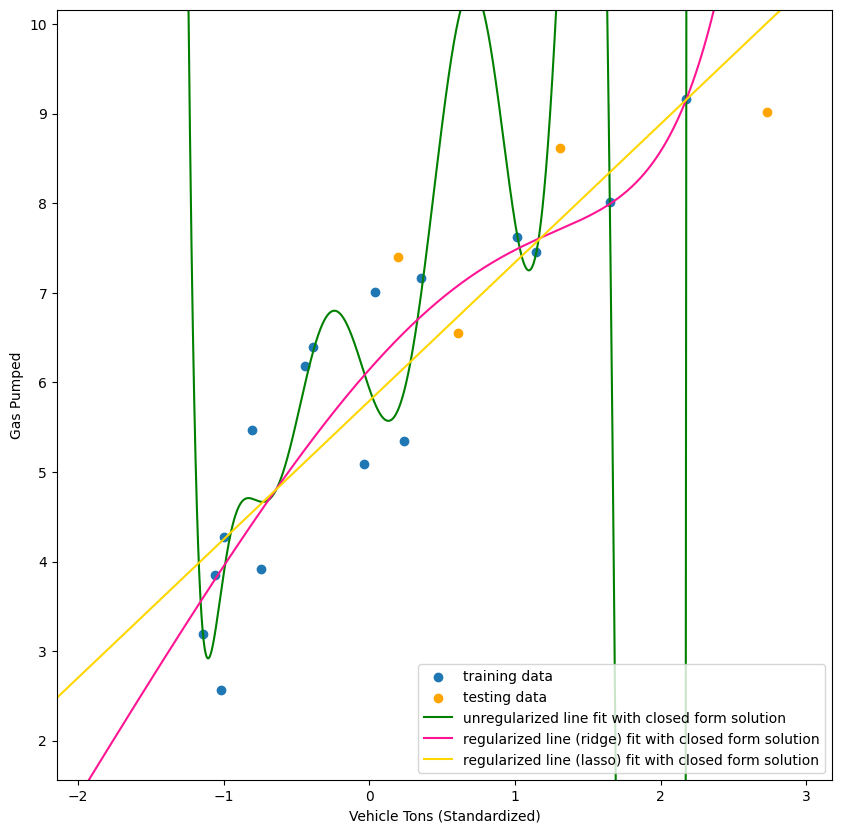

In [30]:
plt.figure(figsize=(10,10))
plt.scatter(X_train_scaled[:, 0], y_train, label='training data')
plt.scatter(X_test_scaled[:, 0], y_test, c='orange', label='testing data')
plt.plot(X_new_scaled[:, 0], reg.predict(X_new_scaled), c='green', label='unregularized line fit with closed form solution')
plt.plot(X_new_scaled[:, 0], ridge_reg.predict(X_new_scaled), c='deeppink', label='regularized line (ridge) fit with closed form solution')
plt.plot(X_new_scaled[:, 0], lasso_reg.predict(X_new_scaled), c='gold', label='regularized line (lasso) fit with closed form solution')
plt.xlim(min(X_train_scaled[:, 0])-1, max(X_train_scaled[:, 0])+1)
plt.ylim(min(y)-1, max(y)+1)
plt.xlabel('Vehicle Tons (Standardized)')
plt.ylabel('Gas Pumped')
plt.legend(loc = 'lower right')
plt.show()

In [31]:
y_pred_train_regged_lasso_closed_form = lasso_reg.predict(X_train_scaled)
y_pred_test_regged_lasso_closed_form = lasso_reg.predict(X_test_scaled)

In [32]:
print(f'Unregularized closed form solution train mean squared error: {mean_squared_error(y_train, y_pred_train_unregged_closed_form)}')
print(f'Unregularized closed form solution test mean squared error: {mean_squared_error(y_test, y_pred_test_unregged_closed_form)}')
print(f'Regularized (ridge) closed form solution train mean squared error: {mean_squared_error(y_train, y_pred_train_regged_closed_form)}')
print(f'Regularized (ridge) closed form solution test mean squared error: {mean_squared_error(y_test, y_pred_test_regged_closed_form)}')
print(f'Regularized (lasso) closed form solution train mean squared error: {mean_squared_error(y_train, y_pred_train_regged_lasso_closed_form)}')
print(f'Regularized (lasso) closed form solution test mean squared error: {mean_squared_error(y_test, y_pred_test_regged_lasso_closed_form)}')

Unregularized closed form solution train mean squared error: 0.3661147036640688
Unregularized closed form solution test mean squared error: 67776693.09950213
Regularized (ridge) closed form solution train mean squared error: 0.5447398425909047
Regularized (ridge) closed form solution test mean squared error: 6.549537140865745
Regularized (lasso) closed form solution train mean squared error: 0.6700397451459232
Regularized (lasso) closed form solution test mean squared error: 0.8373620444753429


In [33]:
elastic_reg = ElasticNet(alpha=0.1, l1_ratio=0.1)
elastic_reg.fit(X_train_scaled, y_train)

ElasticNet(alpha=0.1, l1_ratio=0.1)

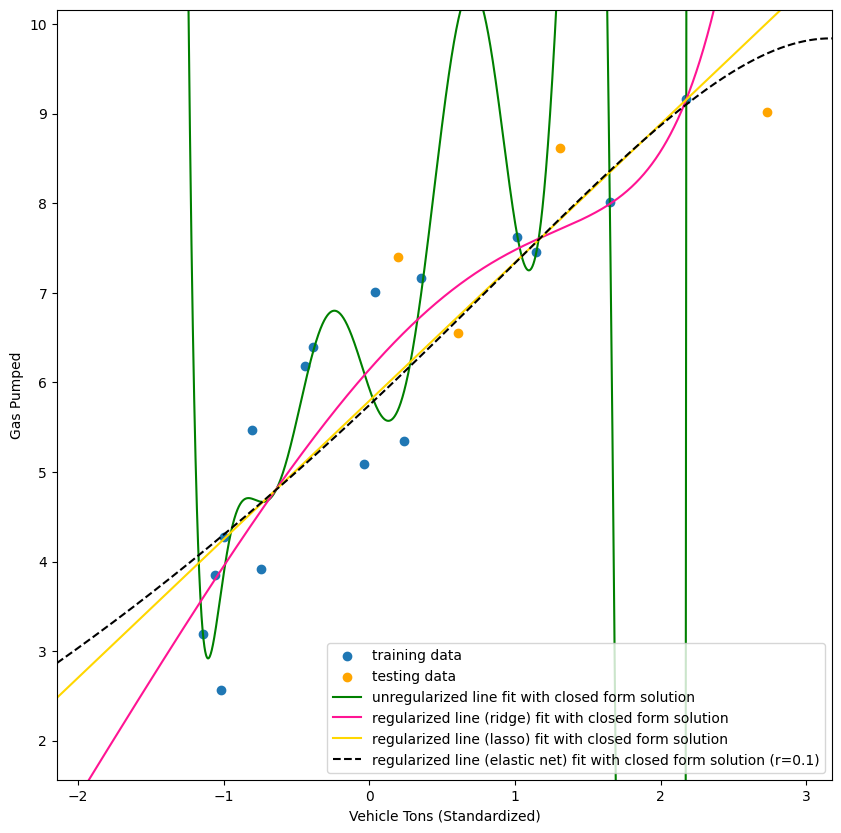

In [34]:
plt.figure(figsize=(10,10))
plt.scatter(X_train_scaled[:, 0], y_train, label='training data')
plt.scatter(X_test_scaled[:, 0], y_test, c='orange', label='testing data')
plt.plot(X_new_scaled[:, 0], reg.predict(X_new_scaled), c='green', label='unregularized line fit with closed form solution')
plt.plot(X_new_scaled[:, 0], ridge_reg.predict(X_new_scaled), c='deeppink', label='regularized line (ridge) fit with closed form solution')
plt.plot(X_new_scaled[:, 0], lasso_reg.predict(X_new_scaled), c='gold', label='regularized line (lasso) fit with closed form solution')
plt.plot(X_new_scaled[:, 0], elastic_reg.predict(X_new_scaled), c='black', label='regularized line (elastic net) fit with closed form solution (r=0.1)', linestyle='dashed')
plt.xlim(min(X_train_scaled[:, 0])-1, max(X_train_scaled[:, 0])+1)
plt.ylim(min(y)-1, max(y)+1)
plt.xlabel('Vehicle Tons (Standardized)')
plt.ylabel('Gas Pumped')
plt.legend(loc = 'lower right')
plt.show()

In [35]:
y_pred_train_regged_elastic_closed_form = elastic_reg.predict(X_train_scaled)
y_pred_test_regged_elastic_closed_form = elastic_reg.predict(X_test_scaled)

In [36]:
print(f'Unregularized closed form solution train mean squared error: {mean_squared_error(y_train, y_pred_train_unregged_closed_form)}')
print(f'Unregularized closed form solution test mean squared error: {mean_squared_error(y_test, y_pred_test_unregged_closed_form)}')
print(f'Regularized (ridge) closed form solution train mean squared error: {mean_squared_error(y_train, y_pred_train_regged_closed_form)}')
print(f'Regularized (ridge) closed form solution test mean squared error: {mean_squared_error(y_test, y_pred_test_regged_closed_form)}')
print(f'Regularized (lasso) closed form solution train mean squared error: {mean_squared_error(y_train, y_pred_train_regged_lasso_closed_form)}')
print(f'Regularized (lasso) closed form solution test mean squared error: {mean_squared_error(y_test, y_pred_test_regged_lasso_closed_form)}')
print(f'Regularized (elastic) closed form solution train mean squared error: {mean_squared_error(y_train, y_pred_train_regged_elastic_closed_form)}')
print(f'Regularized (elastic) closed form solution test mean squared error: {mean_squared_error(y_test, y_pred_test_regged_elastic_closed_form)}')

Unregularized closed form solution train mean squared error: 0.3661147036640688
Unregularized closed form solution test mean squared error: 67776693.09950213
Regularized (ridge) closed form solution train mean squared error: 0.5447398425909047
Regularized (ridge) closed form solution test mean squared error: 6.549537140865745
Regularized (lasso) closed form solution train mean squared error: 0.6700397451459232
Regularized (lasso) closed form solution test mean squared error: 0.8373620444753429
Regularized (elastic) closed form solution train mean squared error: 0.7044851084016288
Regularized (elastic) closed form solution test mean squared error: 0.7211304995122358


In [37]:
step_size = 0.005
filenames = []
plt.ioff()
print(len(np.arange(start=step_size, stop=1, step=step_size)))
import seaborn as sns

for alpha_num, alpha in enumerate(np.arange(start=step_size, stop=1, step=step_size)):
    print(alpha_num)
    lasso_reg = Lasso(alpha=alpha, max_iter=10000)
    lasso_reg.fit(X_train_scaled, y_train)
    print(lasso_reg.predict(np.zeros(X_train_scaled.shape[1]).reshape(1,-1)))
    plt.figure(figsize=(20,10))
    plt.subplot(1, 2, 1)
    #plt.axvline(0, color='black')
    #plt.axhline(5.792863880420886, color='black')
    plt.scatter(X_train_scaled[:, 0], y_train, label='training data')
    plt.scatter(X_test_scaled[:, 0], y_test, c='orange', label='testing data')
    plt.plot(X_new_scaled[:, 0], reg.predict(X_new_scaled), c='green', label='unregularized line fit with closed form solution')
    plt.plot(X_new_scaled[:, 0], lasso_reg.predict(X_new_scaled), c='gold', label='regularized line (lasso) fit with closed form solution')
    plt.xlim(min(X_train_scaled[:, 0])-1, max(X_train_scaled[:, 0])+1)
    plt.ylim(min(y)-1, max(y)+1)
    plt.xlabel('Vehicle Tons (Standardized)')
    plt.ylabel('Gas Pumped')
    plt.legend(loc = 'lower right')

    plt.title(f'Lasso Regression Fit to Points\nAlpha={np.round(alpha,2):.2f}')

    plt.subplot(1,2,2)
    plt.axhline(0, color='black')

    ax = sns.barplot(x=['Intercept']+list(poly.get_feature_names_out()), y=[lasso_reg.intercept_[0].copy()]+list(lasso_reg.coef_))
    ax.bar_label(ax.containers[0], fontsize=10)
    plt.title('Lasso Regression Weights')
    plt.ylim(-7,7)
    plt.xticks(rotation=90)

    fn = f'tmp/lasso_{alpha}.png'
    plt.savefig(fn, bbox_inches='tight')
    filenames.append(fn)
    plt.close()

199
0
[5.79286388]
1
[5.79286388]
2
[5.79286388]
3
[5.79286388]
4
[5.79286388]
5
[5.79286388]
6
[5.79286388]
7
[5.79286388]
8
[5.79286388]
9
[5.79286388]
10
[5.79286388]
11
[5.79286388]
12
[5.79286388]
13
[5.79286388]
14
[5.79286388]
15
[5.79286388]
16
[5.79286388]
17
[5.79286388]
18
[5.79286388]
19
[5.79286388]
20
[5.79286388]
21
[5.79286388]
22
[5.79286388]
23
[5.79286388]
24
[5.79286388]
25
[5.79286388]
26
[5.79286388]
27
[5.79286388]
28
[5.79286388]
29
[5.79286388]
30
[5.79286388]
31
[5.79286388]
32
[5.79286388]
33
[5.79286388]
34
[5.79286388]
35
[5.79286388]
36
[5.79286388]
37
[5.79286388]
38
[5.79286388]
39
[5.79286388]
40
[5.79286388]
41
[5.79286388]
42
[5.79286388]
43
[5.79286388]
44
[5.79286388]
45
[5.79286388]
46
[5.79286388]
47
[5.79286388]
48
[5.79286388]
49
[5.79286388]
50
[5.79286388]
51
[5.79286388]
52
[5.79286388]
53
[5.79286388]
54
[5.79286388]
55
[5.79286388]
56
[5.79286388]
57
[5.79286388]
58
[5.79286388]
59
[5.79286388]
60
[5.79286388]
61
[5.79286388]
62
[5.79286388

In [38]:
reg.coef_[0]

array([-1.68186390e+03,  2.76531582e+04, -2.29101861e+05,  1.15337362e+06,
       -3.73165320e+06,  7.89433556e+06, -1.08248818e+07,  9.24507486e+06,
       -4.45895463e+06,  9.25838497e+05])

In [39]:
import contextlib
from PIL import Image

fp_out = "lasso_convergence.gif"

# use exit stack to automatically close opened images
with contextlib.ExitStack() as stack:

    # lazily load images
    imgs = (stack.enter_context(Image.open(f))
            for f in filenames)

    # extract  first image from iterator
    img = next(imgs)

    # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=100, loop=20)

In [40]:
step_size = 0.005
filenames = []
plt.ioff()
print(len(np.arange(start=step_size, stop=1, step=step_size)))
import seaborn as sns

for alpha_num, alpha in enumerate(np.arange(start=step_size, stop=1, step=step_size)):
    print(alpha_num)
    ridge_reg = Ridge(alpha=alpha, max_iter=10000)
    ridge_reg.fit(X_train_scaled, y_train)
    plt.figure(figsize=(20,10))
    plt.subplot(1, 2, 1)
    #plt.axvline(0, color='black')
    #plt.axhline(0, color='black')
    plt.scatter(X_train_scaled[:, 0], y_train, label='training data')
    plt.scatter(X_test_scaled[:, 0], y_test, c='orange', label='testing data')
    plt.plot(X_new_scaled[:, 0], reg.predict(X_new_scaled), c='green', label='unregularized line fit with closed form solution')
    plt.plot(X_new_scaled[:, 0], ridge_reg.predict(X_new_scaled), c='deeppink', label='regularized line (ridge) fit with closed form solution')
    plt.xlim(min(X_train_scaled[:, 0])-1, max(X_train_scaled[:, 0])+1)
    plt.ylim(min(y)-1, max(y)+1)
    plt.xlabel('Vehicle Tons (Standardized)')
    plt.ylabel('Gas Pumped')
    plt.legend(loc = 'lower right')

    plt.title(f'Ridge Regression Fit to Points\nAlpha={np.round(alpha,2):.2f}')

    plt.subplot(1,2,2)
    plt.axhline(0, color='black')

    ax = sns.barplot(x=['Intercept']+list(poly.get_feature_names_out()), y=[ridge_reg.intercept_[0].copy()]+list(ridge_reg.coef_[0]))
    ax.bar_label(ax.containers[0], fontsize=10)
    plt.title('Ridge Regression Weights')
    plt.ylim(-7,7)
    plt.xticks(rotation=90)
    fn = f'ridge_tmp/ridge_{alpha}.png'
    plt.savefig(fn, bbox_inches='tight')
    filenames.append(fn)
    plt.close()


199
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198


In [41]:
import glob
import contextlib
from PIL import Image

fp_out = "ridge_convergence.gif"

# use exit stack to automatically close opened images
with contextlib.ExitStack() as stack:

    # lazily load images
    imgs = (stack.enter_context(Image.open(f))
            for f in filenames)

    # extract  first image from iterator
    img = next(imgs)

    # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=100, loop=20)